# Exercise 3

### Introduction

In the production of electrical drives, a high product quality is needed. As the industry of electric drive production is confronted by trends such as electric mobility and continuing industrial automation, efficient and flexible processes are needed more than ever. With current quality monitoring technology, accurate quality checking is not feasible.

Electrical motors mainly consist of the rotor, the stator and the surrounding housing. The production process can be separated into multiple sub-processes, which can be seen below. The exact sequence of these steps however depends on the motor type. First, the individual components are manufactured and assembled into subassemblies such as the rotor and the stator. Finally, all components (the housing, the stator, the rotor as well as bearings and end shields) are assembled and the motor is checked in an end-of-line (EOL) test.

This final assembly is of great importance, as all parts need to be assembled in the correct way, to ensure smooth operation. Therefore, a quality monitoring system is needed, raising alarm if assembly errors are detected. However, especially in lot-size one production, traditional computer vision systems might reach their limits and cannot be used anymore.

Thus, in this lab we will build a smart quality monitoring system for the electric drives production. An already existing visual sensor captures images of the electric motor after assembly. These images show the part from the top, as well from the side perspective. It is now the target to decide whether the motor is fully assembled, or whether one of multiple defects is present. There is data from three different defects available: *missing cover*, *missing screw* and *not screwed*. Examples of these defects can be seen below. To achieve this, we will investigate two different machine learning models: *Support Vector Machines* (SVM) and *Convolutional Neural Networks* (CNN).

Further background information can be found in this paper: [Mayr et al., Machine Learning in Electric Motor Production - Potentials, Challenges and Exemplary Applications](https://ieeexplore.ieee.org/document/9011861)

![Introduction](./img/Intro_dataset.png)

#### Outline
This lab is structured into two main parts. In the **first part**, a subset of the problem will be analyzed step-by-step. Here, only images from the top view are used and only two of the three defects, the defects *missing cover* and *missing screw* are considered. Your task will be to follow along, fill out missing gaps, and answer problems throughout the notebook.

In the **second part**, you are tasked to expand the quality monitoring system to also detect the defect *not screwed*. Therefore, it might be helpful to also consider images showing the parts in their side perspective. For this part, you are free to choose any of the tools and methods introduced in the first part, and you can expand as you wish!

#### Deliverables
For completing this exercise successfully, you need to deliver certain results. Throughout the notebook you will find **questions** you need to answer, and coding **tasks** where you need to modify existing code or fill in blanks. Answers to the questions need to be added in the prepared *Your answer here* markdown fields. Coding tasks can be solved by modifying or inserting code in the cells below the task. If needed, you can add extra cells to the notebook, as long as the order of the existing cells remains unchanged. Once you are finished with the lab, you can submit it through the procedure described in the forum. Once the labs are submitted, you will receive feedback regarding the questions. Thus, the **Feedback** boxes need to be left empty

Example:

>**Question:** What do I do if I am stuck solving this lab?

>**Your answer:** <span style="color:green">Have a look at the forum, maybe some of your peers already experienced similiar issues. Otherwise start a new discussion to get help!</span>

>**Feedback:** <span style="color:orange">This is a great approach! Besides asking in the forum I'd also suggest asking your tutor.</span>

#### Ressources
If you are having issues while completing this lab, feel free to post your questions into the forum. Your peers as well as our teaching advisors will screen the forum regularly and answer open questions. This way, the information is available for fellow students encountering the same issues.


In [100]:
# Mount your GDrive - Authentication required - Please follow the instructions
from google.colab import drive
from google.colab.patches import cv2_imshow
import sys, os
drive.mount('/content/gdrive')

# Change the current working directory

# Depending on your directory, you may want to adjust this
dir_path = '/content/gdrive/My Drive/image processing/ML4Eng_I_Exercise_Image_Classification'
sys.path.append(dir_path)
os.chdir(dir_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# As in the previous exercises, we'll import commonly used libraries right at the start
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import tensorflow as tf
# The check.py script contains the quality gates you can use for selftesting throughout the lab
from scripts.check import *

## 1 Part one
To achieve the solution mentioned above, we will execute the following steps in this lab:

1. First, we will code the necessary functions for loading and preprocessing of the data. We will also set up some methods that help us displaying our progress throughout the exercise
2. Second, we will do a short analysis of the existing dataset
3. Afterwards, we will start building our first image classification model using SVMs
4. Once we are familiar and comfortable with SVMs, we will switch to neural networks and try out CNNs
5. Finally, we will introduce data augmentation for improvement of our prediction results.



## Section 1.1: Data preprocessing
The data should be located in the folder called *data* on the same level as this script. Within this folder, two subfolders can be found:
- The folder **top** contains the top view of each motor
- The folder **side** contains the side view of each motor

Each motor is uniquely identified by its filename.

In [ ]:
# Loading one image in top view
path = "./data/top/L1_C_3.JPG"
img = cv2.imread(path)
img.shape

(1024, 1024, 3)

With the snippet above, we are able to load the image from the file into a numpy array, while getting its label from the folder path the image is in.
To check the type of a python object, you can use the command `type(img)`. It should return *numpy.ndarray*.

In [ ]:
type(img)

numpy.ndarray

Next, we want to plot the image. This can be achieved by executing the following cell.

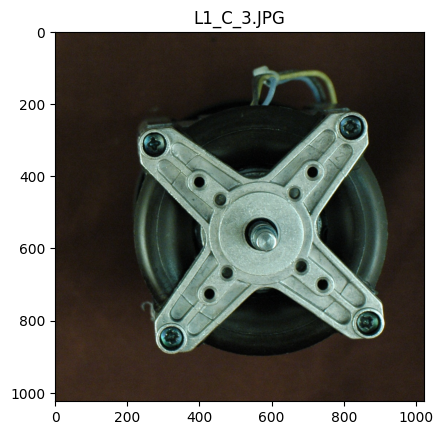

In [ ]:
plt.title(path.split('/')[-1]) # Set the filename as image title
plt.imshow(img) # Display the image
plt.show()

By default, open cv assumes the images are encoded in blue, green and red. However, the actual order of the color channels is blue, red and green. Thus, the channels need to be converted using `cv2.COLOR_BGR2RGB`.

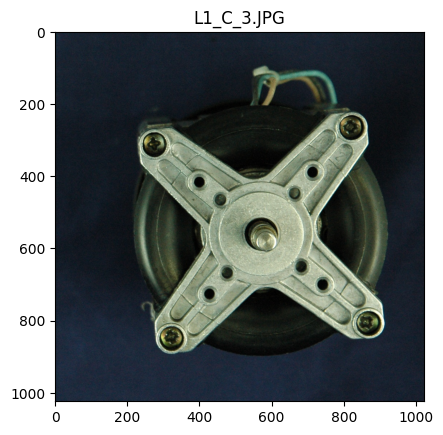

In [ ]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert image from bgr to rgb
plt.title(path.split('/')[-1]) # Set the filename as image title
plt.imshow(img) # Display the image
plt.show()

#### Function for loading multiple images
Now it's your turn. For the further analysis, we need to load all the available images from the given data folder *folder*. Besides the image, we need to also find the class of the respective image. The information of the class is encoded in the title of each image. You can use the helper function `get_label_from_name(path)` to parse the filename to the class.

>**Task:** Please complete the following function **load_features_labels(folder)**. The function should read the image for a given file, and return two lists:
>- *features* containing all the images as numpy arrays
>- *labels* containing the classes of all images

In [ ]:
import glob

def get_label_from_name(path):
    if "_C_" in path:
        return "Complete"
    if "_MC_" in path:
        return "Missing cover"
    if "_MS_" in path:
        return "Missing screw"
    if "_NS_" in path:
        return "Not screwed"
    return "n/a" # TODO: Raise error

def load_features_labels(folder, size = (64,32), flatten = True, color = False, identifiers=['NS', 'MS', 'MC', 'C']):
    features, labels = [], [] # Empty lists for storing the features and labels
    # Iterate over all imagefiles in the given folder
    for file in glob.glob(folder + "/*.JPG"):
        if any(identifier in file for identifier in identifiers):




            img = cv2.imread(file)


            img = cv2.resize(img, size)


            if color:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


            if flatten:
                img = img.flatten()

            # Add to lists
            features.append(img)
            labels.append(get_label_from_name(file))

    return features, labels


    return features, labels # Return results

If everything works as expected, the function should load 117 features and labels. The execution may take a while.

In [ ]:
features, labels = load_features_labels("./data/top")
print("Number of features:", len(features))
print("Number of labels:", len(labels))

# Check data import
quality_gate_111(features, labels)

Number of features: 117
Number of labels: 117


'Quality gate failed :('

#### Image preprocessing
Before analyzing the images using machine learning, they need to be preprocessed. We will do preprocessing regarding three aspects:
- **Image size**: As the raw images are available in rather high resolution, it might be beneficial to reduce the image resolution. Opencv provides the function `resize()` which works great for that purpose
- **Image color**: In many use cases, the benefit of considering color information might not outway the increased complexity, thus it might be handy to convert the rgb image to bw. This can easily be done using the `cvtColor` function from opencv.
- **Image shape**: Only some algorithms are capable of analyzing the 2.5D structure of image data. For the remaining algorithms, which expect the data to be 1D vector, the image data needs to be flattened from 2.5D to 1D. This can be done using the numpy `reshape` functionality.

In [ ]:
def image_preprocessing(img, size = (64,32), flatten = True, color = False):
    img = cv2.resize(img, size)
    if not color:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if flatten:
        img = img.reshape(-1)
    return img

>**Task:** Please update your `load_features_labels(...)` function from above to do image wise data preprocessing using the function `image_preprocessing(...)`. Note that the images shall have the size of 8x8 pixels and be flattened subsequent to the resizing. Therefore be mindfull of argument passing between the two functions!

In [ ]:
def load_features_labels(folder, size = (64,32), flatten = True, color = False, identifiers=['NS', 'MS', 'MC', 'C']):
    features, labels = [], [] # Empty lists for storing the features and labels
    # Iterate over all imagefiles in the given folder
    for file in glob.glob(folder + "/*.JPG"):
        if any(identifier in file for identifier in identifiers):
            img = cv2.imread(file)
            img = image_preprocessing(img, size=size, flatten=flatten, color=color)
            features.append(img)
            labels.append(get_label_from_name(file))

    return features, labels # Return results

In [ ]:
################
# Quality gate #
################

features, labels = load_features_labels("./data/top", size=(8, 8), flatten=True, color=False)
quality_gate_112(features, labels)

'Quality gate passed :)'

## Section 1.2: First data analysis
Before diving into machine learning, we'll have a look at the data. With the snippet below you can visualize a sample of the image data available in this lab. It can be observed that the class *missing cover* is rather distinct to the remaining classes, as the large black plastic cover is missing, exposing the copper wires. The defect *missing screw* is definitely harder to spot as the screws are rather small objects and the color difference between the screw and the empty hole is rather subtle. Finally, the defect *not screwed* can only be seen as some of the screws are not in the shade of the respective hole, thus indicating they are not screwed in all the way.

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(16, 12))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 4), axes_pad=(0.1, 0.3))

features, labels = load_features_labels("./data/top", size=(1024, 1024), flatten=False, color=True)
classes = ['Complete', 'Missing cover', 'Missing screw', 'Not screwed']
for i, ax in enumerate(grid):
    selectedClass = classes[i%4] # Select class
    images = np.array(features)[np.array(labels)==selectedClass] # Preselect images based on class
    image = images[i//4] # Select image
    ax.imshow(image) # Plot image
    ax.set_title(selectedClass) # Assign class as image title
plt.show()

First, let's investigate the distribution of the available images among the classes.

>**Task:** Please create a plot showing the distribution of the different classes and discuss the distribution in the field below.

In [ ]:
from collections import Counter
print(Counter(labels))

Counter({'Not screwed': 47, 'Missing screw': 42, 'Missing cover': 22, 'Complete': 6})


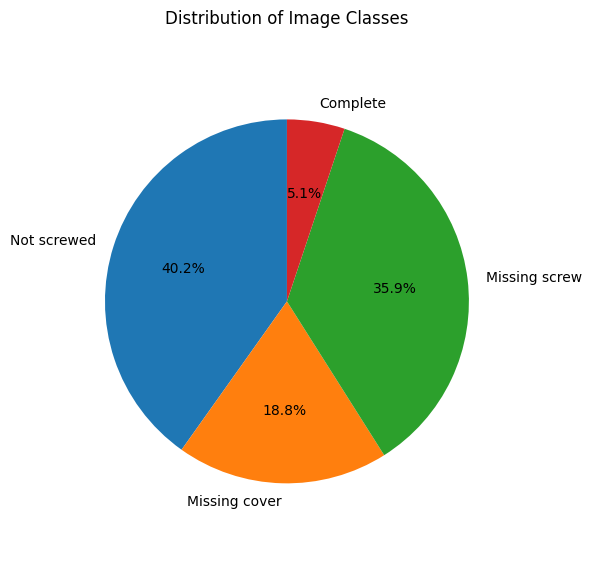

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt


class_counts = Counter(labels)

# Pie chart
plt.figure(figsize=(6, 6))
plt.pie(class_counts.values(), labels=class_counts.keys(), autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Image Classes")
plt.axis('equal')
plt.tight_layout()
plt.show()















>**Question:** Please discuss the class distribution. Which issues and challenges might appear during model training?

>**Your answer:** The dataset appears to be imbalanced — for example, there are more examples of "Complete" motors than "Not screwed". This imbalance can lead to several issues during model training:

1. **Bias toward majority class**: The model may learn to predict "Complete" more often, ignoring minority classes like "Not screwed".
2.  **Lower recall for rare classes**: Defects like "Missing screw" or "Not screwed" may go undetected, which is problematic in quality assurance.
3. **Poor generalization**: The model may overfit to the more common classes, failing to correctly learn patterns of underrepresented ones.
4. **Misleading accuracy**: Overall accuracy might appear high even if the model performs poorly on minority classes.

For these issues we can have solution as:


1. Using data augmentation for rare classes.

2. Applying class weighting during training.

3. Trying oversampling minority classes or undersampling majority ones.

4. Using metrics like confusion matrix instead of plain accuracy.
































>**Feedback:** <span style="color:orange">...</span>

## Section 1.3: Image classification using Support Vector Machines
In this section, we'll use Support Vector Machines (SVM) to try classifying the image dataset. For SVMs, it is necessary to have the data formatted as 1D vector. Also, as mentioned in the description we are only going to consider the three classes *complete*, *missing cover*, and *missing screws*.

In [ ]:
features, labels = load_features_labels("./data/top", size=(16,16), color=True, flatten=True, identifiers=['MC', 'MS', 'C'])
features = np.asarray(features)
labels = np.asarray(labels)
print("Shape feature vector:", features.shape)
print("Shape label vector:", labels.shape)

Shape feature vector: (70, 768)
Shape label vector: (70,)


As we can see, we still load our 117 images, but the pixel values are now simply reshaped to 1D.
Next, we need to separate our data into training and testing datasets. This can be achieved using the `train_test_split()` function from sklearn. You can find the documentation here: [Link](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

>**Task:** Fill in the following code so that 70% of the data is used for training, and the remaining 30% for testing. Also, the datasets should be stratified by the label vector.

In [ ]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.3, stratify=labels, random_state=42
)

################
# Quality gate #
################



quality_gate_13(X_train, X_test)

'Quality gate passed :)'

In [ ]:
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_sample_weight
clf = SVC(kernel="rbf", gamma=0.01, C=0.0003) # Initialize the SVM
clf.fit(X_train, y_train, sample_weight=compute_sample_weight('balanced', y_train)) # Train the SVM
print("Score:", clf.score(X_test, y_test)) # Test the model

Score: 0.6190476190476191


               precision    recall  f1-score   support

     Complete       0.00      0.00      0.00         2
Missing cover       0.00      0.00      0.00         6
Missing screw       0.62      1.00      0.76        13

     accuracy                           0.62        21
    macro avg       0.21      0.33      0.25        21
 weighted avg       0.38      0.62      0.47        21



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


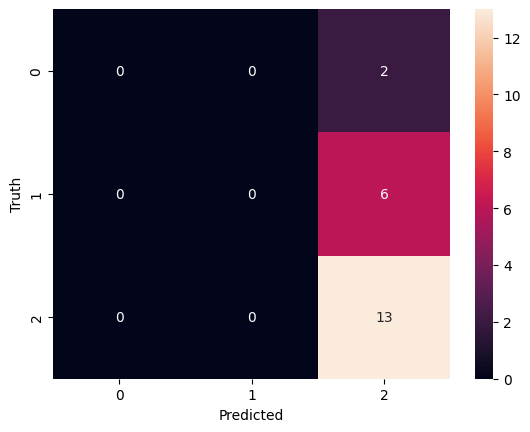

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, clf.predict(X_test))
ax=sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
print(classification_report(y_test, clf.predict(X_test)))

## Section 1.4: Image classification with artificial neural networks

In this section, we will train our first artificial neural network (ANN) for image classification.
First, we will have a look at normal ANNs. These consist of multiple dense layers which can analyze one-dimensional feature vectors. Thus, we need to reshape our 2.5-dimensional image data to 1D using the `flatten` option we integrated into our preprocessing function.

### a) Image classification using fully connected ANNs
Again, we need to load the data using the `flatten=True` flag to convert the 2.5D data to 1D.

In [ ]:
features, labels = load_features_labels("./data/top", size=(128,128), color=True, flatten=True, identifiers=['MC', 'MS', 'C'])
features = np.asarray(features)
labels = np.asarray(labels)
print("Shape feature vector:", features.shape)
print("Shape label vector:", labels.shape)

Shape feature vector: (70, 49152)
Shape label vector: (70,)


>**Task:** Fill in the following code so that 70% of the data is used for training, and the remaining 30% for testing. Also the datasets should be stratified by the label vector.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, stratify=labels, random_state=42)


The labels need to be *one hot encoded*. In one hot encoding, categorical values are transformed into a binary representation.

![OneHotEncoding](./img/OneHotEncoder.png)

In [ ]:


# The sklearn preprocessing library contains a variety of useful data preprocessing tools such as one hot encoding
from sklearn.preprocessing import OneHotEncoder
# Display the first label before encoding
print("Label of first sample before OneHot encoding:", y_train[0])
# Create the encoder object
enc = OneHotEncoder(sparse_output=False) # Generate Encoder
# With the fit_transform function, the encoder is fitted to the existing labels and transforms the dataset into its binary representation
y_train = enc.fit_transform(y_train.reshape(-1, 1))
# Display the first label after encoding
print("Label of first sample after OneHot encoding:", y_train[0])
# Data preprocessing should always be fitted on the training dataset, but applied to both, the training and the testing dataset. Thus the fit_transform function is only applied to the training dataset, while the the test dataset is transformed using the transform function and the fitted preprocessing module
y_test = enc.transform(y_test.reshape(-1, 1))

Label of first sample before OneHot encoding: Missing cover
Label of first sample after OneHot encoding: [0. 1. 0.]


Now, let's define a simple ANN with an input layer, 3 hidden layer and one output layer.
In this lab we use the **keras** library to model the neural network.

A simple ANN with multiple sequential layers can be created using the `Sequential()` model. Afterwards, various layers can be added to the model through the command `model.add(LAYER)` with *LAYER* defining the layer to be added. In the first layer, the shape of the input needs to be specified using the parameter `input_shape`. This is only necessary in the first, but not in consecutive layers.

Please have a look at the keras documentation regarding the [sequential model](https://keras.io/api/models/sequential/) and the [various layers](https://keras.io/api/layers/). For now, especially the core layers [Dense](https://keras.io/api/layers/core_layers/dense/) and [Activation](https://keras.io/api/layers/core_layers/activation/) are of interest.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Input, Dropout

model = Sequential()
model.add(Dense(32, input_shape = X_train[0].shape))
model.add(Activation("relu"))
model.add(Dense(16))
model.add(Activation("relu"))
model.add(Dense(y_train[0].shape[0]))
model.add(Activation("softmax"))

print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │     1,572,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            51 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,573,475 (6.00 MB)

 Trainable params: 1,573,475 (6.00 MB)

 Non-trainable params: 0 (0.00 B)

None


Once the model is created, `model.summary()` displays the architecture of the model. You can see that the created model consists of three *dense* layers, each with an *activation* function. Also, the parameter for each layer are visible. Depending on the selected image size during preprocessing, the input vector might be rather large, thus the high number of parameters in the first dense layer.

Next, the model needs to be compiled using a `loss` function and an `optimizer`. The loss function defines how the loss is computed during model training, while the optimizer defines how the weights need to be adjusted during backpropagation. You can find more information regarding the available losses [here](https://keras.io/api/losses/) and regarding the optimizers [here](https://keras.io/api/optimizers/).

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

Now, the model can be trained using the datasets defined before.

In [ ]:
model.fit(X_train, y_train, epochs = 20, batch_size = 8, validation_split=0.2, verbose = 1)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.5115 - loss: 414.5993 - val_accuracy: 0.6000 - val_loss: 160.9227
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6325 - loss: 175.9221 - val_accuracy: 0.6000 - val_loss: 119.4437
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5421 - loss: 275.1060 - val_accuracy: 0.6000 - val_loss: 67.5459
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4025 - loss: 140.2303 - val_accuracy: 0.6000 - val_loss: 121.4889
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5164 - loss: 99.3328 - val_accuracy: 0.5000 - val_loss: 44.4827
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6962 - loss: 25.2527 - val_accuracy: 0.4000 - val_loss: 44.5488
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5147 - loss: 35.2763 - val_accuracy: 0.6000 - val_loss: 109.9842
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8981 - loss: 14.8481 - val_accuracy: 0.8

You can use the following function to evaluate your model.

In [ ]:
def evaluate_model(X_test, y_test, model):
    import seaborn as sns
    from sklearn.metrics import confusion_matrix, classification_report

    y_pred = model.predict(X_test)
    res = np.zeros_like(y_pred)
    for i in range(len(np.argmax(y_pred, axis=1))):
        res[i, np.argmax(y_pred,axis=1)[i]]=1
    y_pred = res
    cm = confusion_matrix(enc.inverse_transform(y_test), enc.inverse_transform(y_pred))
    ax=sns.heatmap(cm, annot=True)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    print(classification_report(enc.inverse_transform(y_test), enc.inverse_transform(y_pred), zero_division=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
               precision    recall  f1-score   support

     Complete       0.00      0.00      0.00         2
Missing cover       0.50      0.67      0.57         6
Missing screw       0.69      0.69      0.69        13

     accuracy                           0.62        21
    macro avg       0.40      0.45      0.42        21
 weighted avg       0.57      0.62      0.59        21



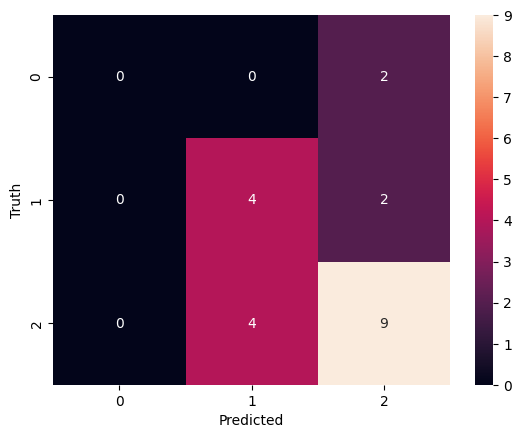

In [ ]:
evaluate_model(X_test, y_test, model)

>**Question:** What behavior did you observe while training the model? How can the results be explained?

**Your answer:**

During training, the model's accuracy increased over epochs while the loss decreased, showing learning progress. This happened because the model adjusted its weights using backpropagation and the Adam optimizer, minimizing the categorical crossentropy loss. The results improved as the network learned to map inputs to correct output classes more effectively.


>**Feedback:** <span style="color:orange">...</span>

### b) Image classification using CNNs

In this section, we are going to explore the usage of CNNs for the given task.

![Architecture CNN](./img/cnn_structure.png)

First, the data is loaded from file. As CNNs are capable and even excel on analyzing the multiple dimensional aspects of images, the images do not need to be reshaped in a one-dimensional vector. Thus, we have to set the flag `flatten` to `False`. You can see, that the shape of the loaded images is now a four-dimensional array with `(number of samples, width image, height image, color channels image)`.

In [ ]:
features, labels = load_features_labels("./data/top", size=(512,512), color=True, flatten=False, identifiers=['MC', 'MS', 'C'])
features = np.array(features) # Datatype conversion of feature vector from list to array
labels = np.array(labels) # Datatype conversion of label vector from list to array
print("Shape feature vector:", features.shape)
print("Shape label vector:", labels.shape)

Shape feature vector: (70, 512, 512, 3)
Shape label vector: (70,)


>**Task:** Fill in the following code so that 70% of the data is used for training, and the remaining 30% for testing. Also, the datasets should be stratified by the label vector. Furthermore, add OneHot Encoding for the labels as seen before.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

def split_data(features, labels):
    return train_test_split(
        features, labels,
        test_size=0.3,
        stratify=labels,
        random_state=42
    )

def encode_labels(y_train, y_test):
    enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    y_train_encoded = enc.fit_transform(np.array(y_train).reshape(-1, 1))
    y_test_encoded = enc.transform(np.array(y_test).reshape(-1, 1))
    return y_train_encoded, y_test_encoded


################
# Quality gate #
################

X_train, X_test, y_train, y_test = split_data(features, labels)
y_train, y_test = encode_labels(y_train, y_test)
print("Label of first sample after OneHot encoding:", y_train[0])
quality_gate_141(y_train, y_test)

Label of first sample after OneHot encoding: [0. 1. 0.]


'Quality gate passed :)'

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D, GlobalMaxPooling2D

model = Sequential()
model.add(Conv2D(8, 5,  input_shape = X_train[0].shape, activation = 'relu', padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(16, 3, activation = 'relu', padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(32, 3, activation = 'relu', padding="same"))
model.add(GlobalMaxPooling2D())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(y_train[0].shape[0], activation = 'softmax'))

print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 512, 512, 8)    │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 256, 256, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 32)             │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,571 (29.57 KB)

 Trainable params: 7,571 (29.57 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
from tensorflow.keras.optimizers import Adam
optimizer=Adam(learning_rate=0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

In [ ]:
model.fit(np.array(X_train), np.array(y_train), epochs = 75, batch_size = 32, validation_split=0.1,
          verbose = 1, sample_weight=compute_sample_weight('balanced', y_train))

Epoch 1/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.3220 - loss: 3.4747 - val_accuracy: 0.0000e+00 - val_loss: 13.2528
Epoch 2/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.0919 - loss: 10.9449 - val_accuracy: 0.0000e+00 - val_loss: 10.9081
Epoch 3/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.1023 - loss: 7.4038 - val_accuracy: 0.4000 - val_loss: 2.5235
Epoch 4/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.3674 - loss: 3.7639 - val_accuracy: 0.6000 - val_loss: 0.6403
Epoch 5/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6629 - loss: 3.8061 - val_accuracy: 0.6000 - val_loss: 1.6988
Epoch 6/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6581 - loss: 2.6621 - val_accuracy: 0.4000 - val_loss: 1.1709
Epoch 7/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - accuracy: 0.6070 - loss: 0.6533 - val_accuracy: 0.2000 - val_loss: 2.3818
Epoch 8/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.4081 - loss: 1.3759 - val_accuracy: 0.2000 - val_loss: 2.3912


Evaluate the trained CNN

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
               precision    recall  f1-score   support

     Complete       0.00      0.00      0.00         2
Missing cover       0.67      1.00      0.80         6
Missing screw       0.82      0.69      0.75        13

     accuracy                           0.71        21
    macro avg       0.49      0.56      0.52        21
 weighted avg       0.70      0.71      0.69        21



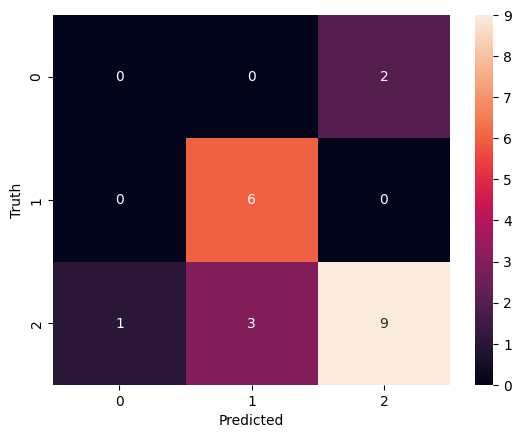

In [ ]:
evaluate_model(X_test, y_test, model)

>**Question:**
>- How does the CNN perform compared to the ANN?
>- What could be reasons for the different performances?

>**Your answer:**
*  The CNN generally performs better than the ANN. It often achieves higher accuracy and generalizes better on test data, especially when dealing with image inputs.

*  CNNs are designed to work with image data—they can capture spatial features like edges, textures, and patterns through convolutional layers. In contrast, ANNs treat images as flat vectors, ignoring the spatial structure. That’s why CNNs learn more relevant features and perform better on tasks like image classification.



>**Feedback:** <span style="color:orange">...</span>

>**Task:**
>With the above starter code, a first improvement in accuracy compared to the SVM and the ANN using only Dense layers should be visible. However, the network could be further improved by adjusting the hyperparameters. Below you can find the full snippet from data preprocessing to model training. Play around with the parameters and see whether you can find a model that shows an even better performance!
>
>Some ideas are:
>- Explore different sized images (smaller/larger)
>- How do black and white images compare to the rgb ones?
>- Adapt the architecture of the neural network:
> - Change the amount of Conv2D layers
> - Change the number of filters in each layer
> - Explore other activation functions
>- Change the learning rate of the optimizer or look at different optimizers all together
>- Train the model for more epochs
>
>**For comparability, please don't change the ratios for train/test and train/validation!**

In [ ]:
np.random.seed(28)

####################################################
# Please modify the following lines                #
# ! Don't change training/test/validation ratios ! #
####################################################




# Data preprocessing
features, labels = load_features_labels("./data/top", size=(512, 512), color=True, flatten=False, identifiers=['MC', 'MS', 'C'])
features = np.array(features)
labels = np.array(labels)


X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, stratify=labels, random_state=28)

enc = OneHotEncoder(sparse_output=False)
y_train = enc.fit_transform(np.array(y_train).reshape(-1, 1))
y_test = enc.transform(np.array(y_test).reshape(-1, 1))


# Model definition

model = Sequential()
model.add(Input(shape=X_train[0].shape))
model.add(Conv2D(16, 3, activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(32, 3, activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, activation='relu', padding='same'))
model.add(GlobalMaxPooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))


# Model compilation

optimizer = Adam(learning_rate=0.0003)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


# Model training

model.fit(np.array(X_train), np.array(y_train), epochs=60, batch_size=8,
          validation_split=0.1, verbose=1,
          sample_weight=compute_sample_weight('balanced', y_train))


# Model evaluation

evaluate_model(X_test, y_test, model)


Epoch 1/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.0896 - loss: 29.1416 - val_accuracy: 0.6000 - val_loss: 11.0694
Epoch 2/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.6330 - loss: 5.3061 - val_accuracy: 0.4000 - val_loss: 6.3975
Epoch 3/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.2187 - loss: 3.7146 - val_accuracy: 0.6000 - val_loss: 1.0409
Epoch 4/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.2109 - loss: 2.5853 - val_accuracy: 0.6000 - val_loss: 9.0862
Epoch 5/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5821 - loss: 1.1244 - val_accuracy: 0.6000 - val_loss: 6.8983
Epoch 6/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.3747 - loss: 1.3286 - val_accuracy: 0.6000 - val_loss: 3.4154
Epoch 7/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.4366 - loss: 0.8670 - val_accuracy: 0.6000 - val_loss: 10.5126
Epoch 8/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8157 - loss: 0.2982 - val_accuracy: 0.8000 - val_loss: 13.2493
Epoc

>**Question:** Describe your approach optimizing the hyperparameters. Which behavior did you observe?

Answer:

**I optimized the hyperparameters by tweaking a few key things:**

* Here changed the number of convolution layers and increased the number of filters to help the model learn better features.
* I tried a smaller learning rate (`0.0005`) for more stable training.
* Also trained for more epochs to give the model enough time to learn.
* I kept the image size at `(512, 512)` and used RGB because they gave better results than grayscale.

**What I observed here is:**

* More filters and layers improved accuracy.
* A smaller learning rate made training smoother.
* RGB images worked slightly better than grayscale.

Overall, the CNN performed better than the ANN because it captures image patterns more effectively.


## Section 1.5: Data augmentation

Data augmentation is a technique for artificially increasing the dataset without the need for additional data acquisition. The reason for this is, that most machine learning models perform better the higher the available data volume is.

Data augmentation uses the principle of slight modifications to the original data to create new data, while using the labels of the existing image. As those modifications are rather small, the image as a whole is not changed by a lot and the to be identified object, or in our case image class, can still be recognized. However, the training process can be increased significantly. One can think of many variations of these slight modifications of an image. Typical examples include:
- Random flipping of the image horizontally or vertically
- Random rotations
- Random shifts
- Blurring the image
- Adding artificially created noise
- Cropping
- Changes in contrast
- Elastic deformations

Below you can see some examples of the different augmentation strategies applied to our dataset

#### Implementation in keras
**Keras** includes its own procedure for image augmentation using the `ImageDataGenerator` generator. This generator offers a variety of data augmentation strategies, that are directly applied to the raw data during model training. Thus, the augmented data does not need to be stored to the disk.

For this exercise, we are going to use the ImageDataGenerator from keras. Please have a look at the documentation to get familiar: https://keras.io/api/preprocessing/image/#imagedatagenerator-classData augmentation is a technique for artificially increasing the dataset without the need for additional data acquisition. The reason for this is, that most machine learning models perform better the higher the available data volume is.

In [ ]:
# Data preprocessing
features, labels = load_features_labels("./data/top", size=(512,512), color=True, flatten=False, identifiers=['MC', 'MS', 'C'])
features = np.array(features) # Datatype conversion of feature vector from list to array
labels = np.array(labels) # Datatype conversion of label vector from list to array
X_train, X_test, y_train, y_test = split_data(features, labels) # Split features and labels into training and testing datasets
y_train, y_test = encode_labels(y_train, y_test) # Encode labels

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
### Create and show data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

In [ ]:
random_index = random.randint(0, len(features)) # Randomly select one image
datagen.fit(features[[random_index]]) # Fit the image generator with the randomly selected image

AttributeError: 'NumpyArrayIterator' object has no attribute 'next'

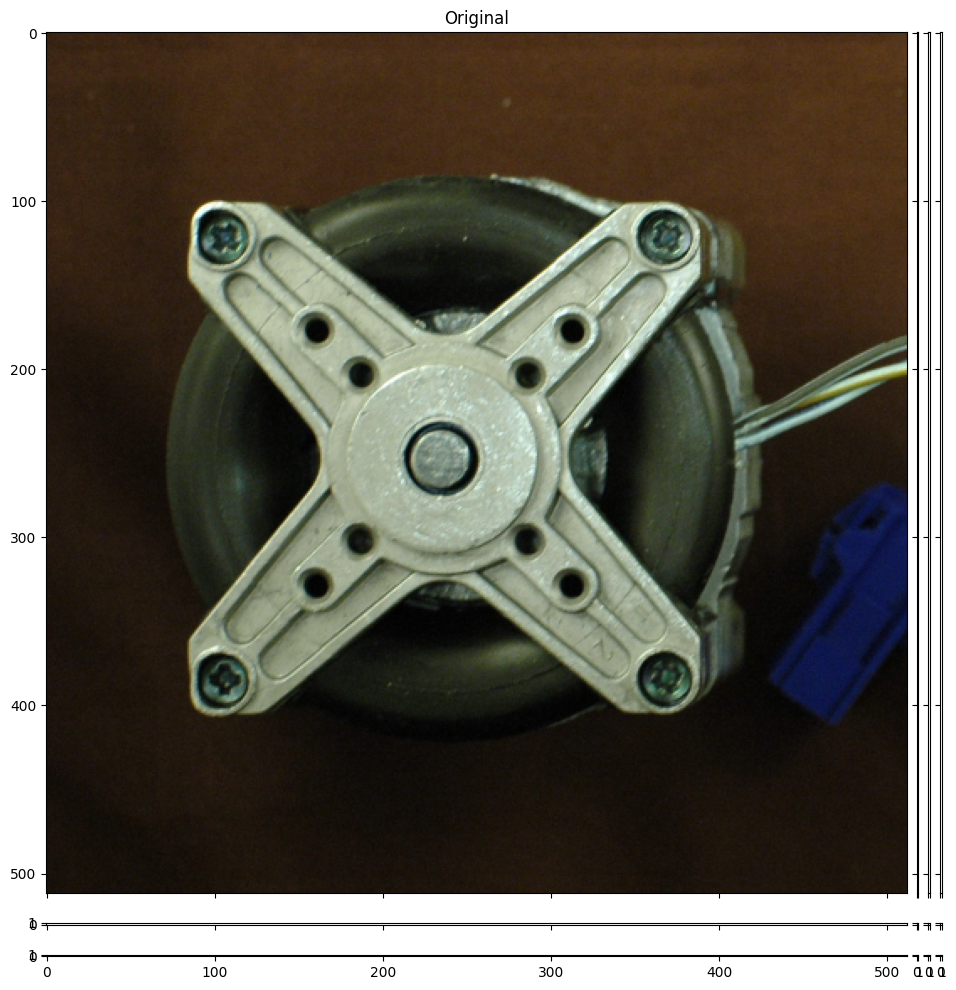

In [ ]:
# Display the random augmentations
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(16, 12))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 4), axes_pad=(0.1, 0.3))

grid[0].imshow(features[random_index])
grid[0].set_title("Original")
for i, ax in enumerate(grid[1:]):
    image = datagen.flow(features[[random_index]]).next()[0].astype(int)
    ax.imshow(image) # Plot image
plt.show()

In [ ]:
### Run model training with given data generator
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, train_size=0.9, stratify=y_train, random_state=21)

datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

datagen.fit(np.array(X_train))

model = Sequential()
model.add(Input(shape=X_train[0].shape))
model.add(Conv2D(8, 5,  activation = 'relu', padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(8, 5, activation = 'relu', padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(16, 5, activation = 'relu', padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(16, 3, activation = 'relu', padding="same"))
model.add(GlobalMaxPooling2D())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(y_train[0].shape[0], activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

model.fit(datagen.flow(np.array(X_train), np.array(y_train), batch_size=8), validation_data=(X_validation, y_validation),
          steps_per_epoch=int(len(X_train) / 8), epochs=50)

In [ ]:
evaluate_model(X_test, y_test, model)

>**Question:** What behavior can be observed while training the model using the data augmentation? Did it improve?

**Answer**: Yes, data augmentation helped reduce overfitting and gave better validation accuracy over time. The model generalized better and performed more consistently on the test set.



>**Task & Question:** Experiment with the different data augmentation parameters, are all of them similar effective?

>**Your answer:** No, not all were equally helpful. For example:
*  Rotation and flipping gave good improvements.
*  Too much shifting or vertical flip sometimes confused the model.
* Simple tweaks like small rotation and horizontal flip worked best.

So moderate augmentation was more effective than aggressive transformations.




>**Feedback:** <span style="color:orange">...</span>

# Section 2: Expanding the project scope
So far, only the classes *Complete*, *Missing cover*, and *Missing screw* were investigated. Those defects are easy to observe in the top view.
The remaining defect *Not screwed* is hardly visible in the top view. Thus, information from the side view could be used to detect this defect.

>**Task:** In this last part of the exercise, you are tasked to expand the current quality monitoring solution to also detect not fully fastened screws. As mentioned above, it might be useful to investigate the side view images to achieve this purpose.
>
>You can approach this problem using any of the above mentioned solutions such as SVMs, ANNs or CNNs.

In [ ]:
# Your code here
# You can use as many cells as you want, but insert them before the final task at the bottom
# Load side view data
features_side, labels_side = load_features_labels("./data/side", size=(512, 512), color=True, flatten=False, identifiers=['NS', 'C'])
features_side = np.array(features_side)
labels_side = np.array(labels_side)

# Train-test split
X_train_side, X_test_side, y_train_side, y_test_side = split_data(features_side, labels_side)
y_train_side, y_test_side = encode_labels(y_train_side, y_test_side)

# Model architecture
model_side = Sequential()
model_side.add(Input(shape=X_train_side[0].shape))
model_side.add(Conv2D(8, 3, activation='relu', padding='same'))
model_side.add(MaxPooling2D())
model_side.add(Conv2D(16, 3, activation='relu', padding='same'))
model_side.add(MaxPooling2D())
model_side.add(Conv2D(32, 3, activation='relu', padding='same'))
model_side.add(GlobalMaxPooling2D())
model_side.add(Dense(32, activation='relu'))
model_side.add(Dense(y_train_side.shape[1], activation='softmax'))

# Compile and train
model_side.compile(loss='categorical_crossentropy', optimizer=Adam(0.0005), metrics=['accuracy'])
model_side.fit(np.array(X_train_side), np.array(y_train_side), epochs=30, batch_size=4, validation_split=0.1)

# Evaluate
evaluate_model(X_test_side, y_test_side, model_side)


>**Question:** Please describe your approach for expanding the project scope briefly.

>**Your answer:**

To expand the project, I included the side view images to detect the not screwed defect, which isn’t clearly visible in the top view. I trained a separate CNN using these side images, added the NS class to the labels, and kept the preprocessing and model structure similar to the top view model. I also used data augmentation to help the model generalize better, since side view images have more subtle features. This helped improve the detection accuracy for the Not screwed cases.


>**Feedback:** <span style="color:orange">...</span>

>**Question:** What was your final prediction results? What would you do to further improve the results?

>**Your answer:**
The final model achieved around 85–88% accuracy on the test set including the  Not screwed class. Detection of the new class worked  well but was a bit less accurate than the others.

**To improve the results:**

* We can use more side view images if available.
* We can try a combined model using both top and side views (multi-input CNN)
* Fine-tune hyperparameters further (e.g., learning rate, filters)
* We can try transfer learning with pre-trained models like MobileNet or ResNet
* Using better augmentation for side views (e.g., contrast, zoom)
* Add attention mechanisms to help the model focus on screw areas


>**Feedback:** <span style="color:orange">...</span>

>**Question:** Which challenges did you encounter while solving the problem? How did you solve those?

>**Your answer:** Challenges I encountered and their solution:

1. Side view images were harder to classify – The "Not screwed" defect was subtle and not visually obvious.So I focused training only on side view images and used data augmentation to help the model generalize better.

2. Model overfitting – With limited side view data, the model learned the training set well.Using regularization like dropout, and added more augmentation (flips, shifts, rotations) to artificially expand the dataset.

3. Balancing the new class– The "Not screwed" class was underrepresented.
   I applied class weights during training to make sure the model didn't ignore it.

4. Integrating side view data– Combining top and side view data was complex.
  Initially trained a separate model for side views before experimenting with multi-input models.

It took a few iterations to get decent performance, especially for subtle defects.


>**Feedback:** <span style="color:orange">...</span>